<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">

# Dow Jones DNA NLP Case Study

_Based on news articles related to Hurricane Harvey._

**Basic Techniques and Algorithms**

Dr Yves J Hilpisch

The Python Quants GmbH

## The Imports

In [1]:
import os
import sys
sys.path.append('../../modules')
import warnings; warnings.simplefilter('ignore')

In [2]:
import nltk
import pprint
import collections
import pandas as pd
from pylab import plt
import nlp_functions as nlp
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from gensim.summarization import keywords
from gensim.summarization.summarizer import summarize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# to be executed once
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

## Raw Data

In [4]:
project = 'harvey_250'

In [5]:
abs_path = os.path.abspath('../../')

In [6]:
data_path = os.path.join(abs_path, 'data_harvey')

In [7]:
snapshot_path = os.path.join(data_path, 'snapshot')

In [8]:
fn = os.path.join(snapshot_path, 'snapshot_{}.h5'.format(project))

In [9]:
raw = pd.read_hdf(fn, 'data')

## Data Selection

In [10]:
sel = raw[raw['body'].apply(lambda s: s.find('government') != -1)]

In [11]:
len(sel)

55

In [12]:
titles = sel['title']

In [13]:
dates = sel['publication_date'].values.tolist()

In [14]:
dates = [pd.Timestamp(date * 1000000) for date in dates]

In [15]:
data = sel['body'].values.tolist()

## Basic Text Analytics

In [16]:
tokens = nlp.tokenize(' '.join(data))

In [17]:
tokens = nltk.word_tokenize(' '.join(data))

In [18]:
text = nltk.Text(tokens)

In [19]:
text.count('government')

94

In [20]:
text.count('hurricane')

71

In [21]:
text.similar('storm')

state hurricane city country company president year island government
day water time system area market dollar floodwaters flooding disaster
county


In [22]:
text.common_contexts(['government', 'president'])

the_of the_may the_said the_will the_s the_has


In [23]:
text.collocations()

Puerto Rico; Hurricane Harvey; United States; block-time published-
time; Operating Profit; third quarter; Donald Trump; Hurricane Irma;
Segment Operating; last year; President Donald; North Korea; Tropical
Storm; Red Cross; New York; South Carolina; White House; Diluted
Earnings; load serving; serving entities


In [24]:
text.concordance('government', width=70, lines=7)

Displaying 7 of 96 matches:
`` too late . '' Read more US government agency drops several referenc
eparation for the storm , the government of economically struggling Pu
full resources of the federal government as Floridians prepare for Hur
ty fees . In a court filing , government lawyers said the airline 's f
In 2013 and 2015 , faced with government funding deadlines and impendi
t his threats to shutdown the government over his proposed border wall
n his threats to shutdown the government if Congress does not agree to


In [25]:
text.concordance('help', width=70, lines=7)

Displaying 7 of 78 matches:
oncerned about acting swiftly to help regular people back home . In co
 that Trump wants to cut FEMA to help pay for his unneeded/unwanted wa
er generators and batteries , to help residents prepare . Telemundo TV
is with them and stands ready to help . Our thoughts and prayers are w
have yet to go home . If you can help please make a donation https : /
water and sewage plants to offer help , she said . The most common flo
st beautiful , everyone wants to help out , ” said one fire department


## Similarity

In [26]:
vec = nlp.TfidfVectorizer(stop_words='english')

In [27]:
mat = vec.fit_transform(data)

In [28]:
(mat * mat.T).A.round(2)

array([[1.  , 0.19, 0.11, ..., 0.17, 0.23, 0.06],
       [0.19, 1.  , 0.05, ..., 0.24, 0.17, 0.04],
       [0.11, 0.05, 1.  , ..., 0.08, 0.04, 0.01],
       ...,
       [0.17, 0.24, 0.08, ..., 1.  , 0.07, 0.05],
       [0.23, 0.17, 0.04, ..., 0.07, 1.  , 0.07],
       [0.06, 0.04, 0.01, ..., 0.05, 0.07, 1.  ]])

## Word Clouds

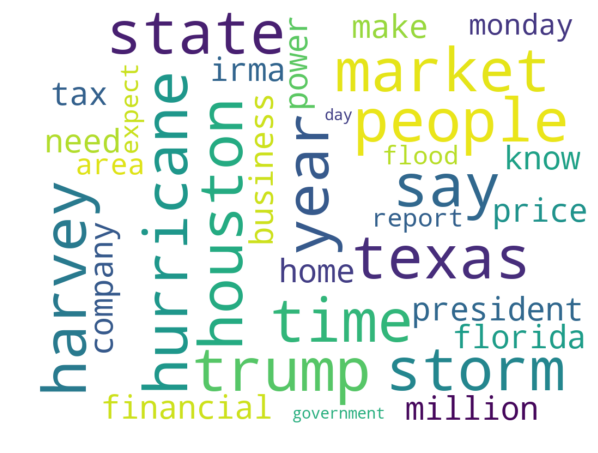

In [29]:
nlp.generate_word_cloud(''.join(data), 35,
                       name='wc_harvey.png')

## Topic Modeling

### NMF Clustering

In [30]:
vec = nlp.TfidfVectorizer(stop_words='english')

In [31]:
mat = vec.fit_transform(data)

In [32]:
nmf = NMF(n_components=6)

In [33]:
nmf.fit(mat)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [34]:
nmf.components_.round(3)

array([[0.   , 0.036, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.055, 0.   , ..., 0.   , 0.   , 0.001],
       [0.   , 0.033, 0.   , ..., 0.   , 0.002, 0.001],
       [0.   , 0.102, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.002, 0.02 , 0.007, ..., 0.   , 0.004, 0.   ],
       [0.004, 0.016, 0.   , ..., 0.003, 0.   , 0.001]])

In [35]:
feature_names = vec.get_feature_names()

In [36]:
n_words = 6

In [37]:
for i, topic in enumerate(nmf.components_[:n_words]):
    print('TOPIC %d'% (i))
    print(60 * '=')
    print(', '.join([feature_names[i] for i in
                     topic.argsort()[:-n_words-1:-1]]) + '\n')

TOPIC 0
puerto, rico, said, island, military, response

TOPIC 1
wsj, et, com, says, year, company

TOPIC 2
trump, congress, president, republicans, tax, states

TOPIC 3
houston, said, city, texas, port, farenthold

TOPIC 4
percent, fed, tax, rate, quarter, market

TOPIC 5
storm, irma, florida, hurricane, monday, tropical



## Summarization

In [38]:
for i, text in enumerate(data[:3]):
    print('\nTEXT {}\n'.format(i) + 50 * '=')
    kws = keywords(text, words=8, split=False,
                   lemmatize=True, scores=True)
    pprint.pprint(kws)


TEXT 0
[('hurricanes', 0.2949522436141287),
 ('trump', 0.23284571338586937),
 ('new', 0.17615684277184462),
 ('texas', 0.16492273104458494),
 ('storms', 0.1624856713445503),
 ('thursday', 0.15997571441854458),
 ('forecasting', 0.13144174819735435),
 ('state', 0.1149109151341786)]

TEXT 1
[('hurricane', 0.29513943035306156),
 ('powerful', 0.20326045900383588),
 ('florida', 0.20109025546026216),
 ('said', 0.19277995569602724),
 ('prepare', 0.1865060532268334),
 ('irma', 0.16506162990437384),
 ('residents', 0.12559096057787852),
 ('puerto', 0.12452231891491328)]

TEXT 2
[('supporting', 0.30005589967011054),
 ('connecticut', 0.22492029021076806),
 ('nation', 0.1917406364176614),
 ('general', 0.1595362866345126),
 ('airlift', 0.15763706524617052),
 ('said', 0.14869479271168004),
 ('critical', 0.14199168512582522),
 ('syndigate', 0.14199168512582402)]


In [39]:
for i, text in enumerate(data[:3]):
    print('\nTEXT {}\n'.format(i) + 50 * '=')
    print(summarize(text, word_count=35))


TEXT 0
A brief-but-haunting video released by NASA Thursday night shows the storm's powerful churn toward Central Texas: "The footage was captured just after 6 p.m. by cameras aboard the International Space Station, not long after the tropical cyclone - aided by warm water and favorable winds - regenerated over the Gulf of Mexico," per The Post's Andrew deGrandpre.

TEXT 1
Hurricane warnings and watches were in effect for parts of the Leeward Islands, the British and US Virgin Islands and Puerto Rico, in preparation for a storm that was intensifying with 240 km/h winds, the US National Hurricane Center said.

TEXT 2
I thank our Connecticut Air National Guardsmen for taking on this mission to give Texas aid during this great time of need.
I want to thank the Connecticut Air National Guardsmen deploying to Texas, and their families, for their service, Lt. Governor Nancy Wyman said.


## Sentiment Analysis

In [40]:
sid = SentimentIntensityAnalyzer()

In [41]:
scores = [sid.polarity_scores(text) for text in data]

In [42]:
scores = pd.DataFrame(scores, index=dates)

In [43]:
scores.head()

,compound,neg,neu,pos
2017-08-25 15:03:00,-0.9975,0.100,0.837,0.062
2017-09-06 00:00:00,-0.9724,0.089,0.882,0.029
2017-08-29 00:00:00,0.9819,0.044,0.810,0.146
2017-08-25 03:14:00,0.9811,0.049,0.869,0.081
2017-09-07 00:00:00,-0.7003,0.107,0.796,0.096


In [44]:
scores.sort_index(inplace=True)

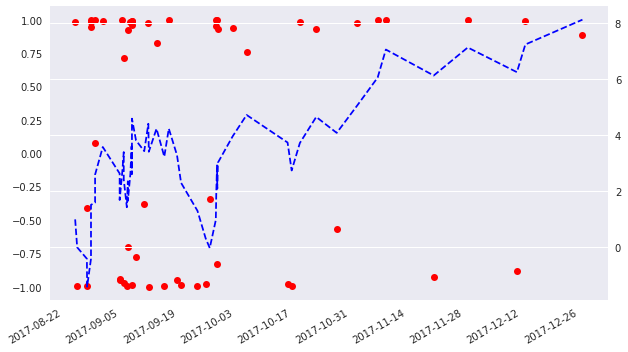

In [45]:
ax = scores['compound'].plot(figsize=(10, 6), style='ro')
scores['compound'].cumsum().plot(ax=ax, style=['b--'], secondary_y='compound');

<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">